<a href="https://colab.research.google.com/github/badhon4772/Computer-Vision-and-Deep-Learning-in-Medical-Imaging/blob/main/Brain%20Tumor%20MRI%20Classification%20with%20DenseNet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Mri Image Classification | DenseNet201

DenseNet201 model for feature extraction and perform classification with ANN. By Nazmul Huda Badhon.

The dataset is collected from kaggle. Here is the link: "https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset"


In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


unziping the datafile.

In [67]:
import zipfile
import os

# Path to the .zip file
zip_file_path = '/content/drive/MyDrive/datasets/Brain Tumor MRI Dataset.zip'
extract_path = 'dataset'

# Extract the .zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to: {extract_path}")

Dataset extracted to: dataset


In [68]:
import numpy as np
import pandas as pd
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2'

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, InputLayer, Conv2D, MaxPool2D, GlobalAveragePooling2D, BatchNormalization, Activation, ReLU, Flatten, Dense, Add, Dropout
from tensorflow.keras.optimizers import  Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from PIL import Image
#from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions
from tensorflow.keras.applications import VGG16, MobileNetV2, DenseNet201

Defining the training and validation data

In [69]:
img_size = 128
batch_size = 32

#data augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.1,
        validation_split=0.2
)

train_set = train_datagen.flow_from_directory('/content/dataset/Training',
                                                  target_size = (img_size, img_size),
                                                  batch_size=batch_size,
                                                  color_mode='rgb',
                                                  shuffle=True,
                                                  class_mode='categorical',
                                                  subset='training',
                                                  interpolation='bicubic')

val_set = train_datagen.flow_from_directory('/content/dataset/Training',
                                                  target_size = (img_size, img_size),
                                                  batch_size=batch_size,
                                                  color_mode='rgb',
                                                  class_mode='categorical',
                                                  subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory('/content/dataset/Testing',
                                                  target_size = (img_size, img_size),
                                                  batch_size=batch_size,
                                                  color_mode='rgb',
                                                  class_mode='categorical')

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


Plotting training images with respective Class labels

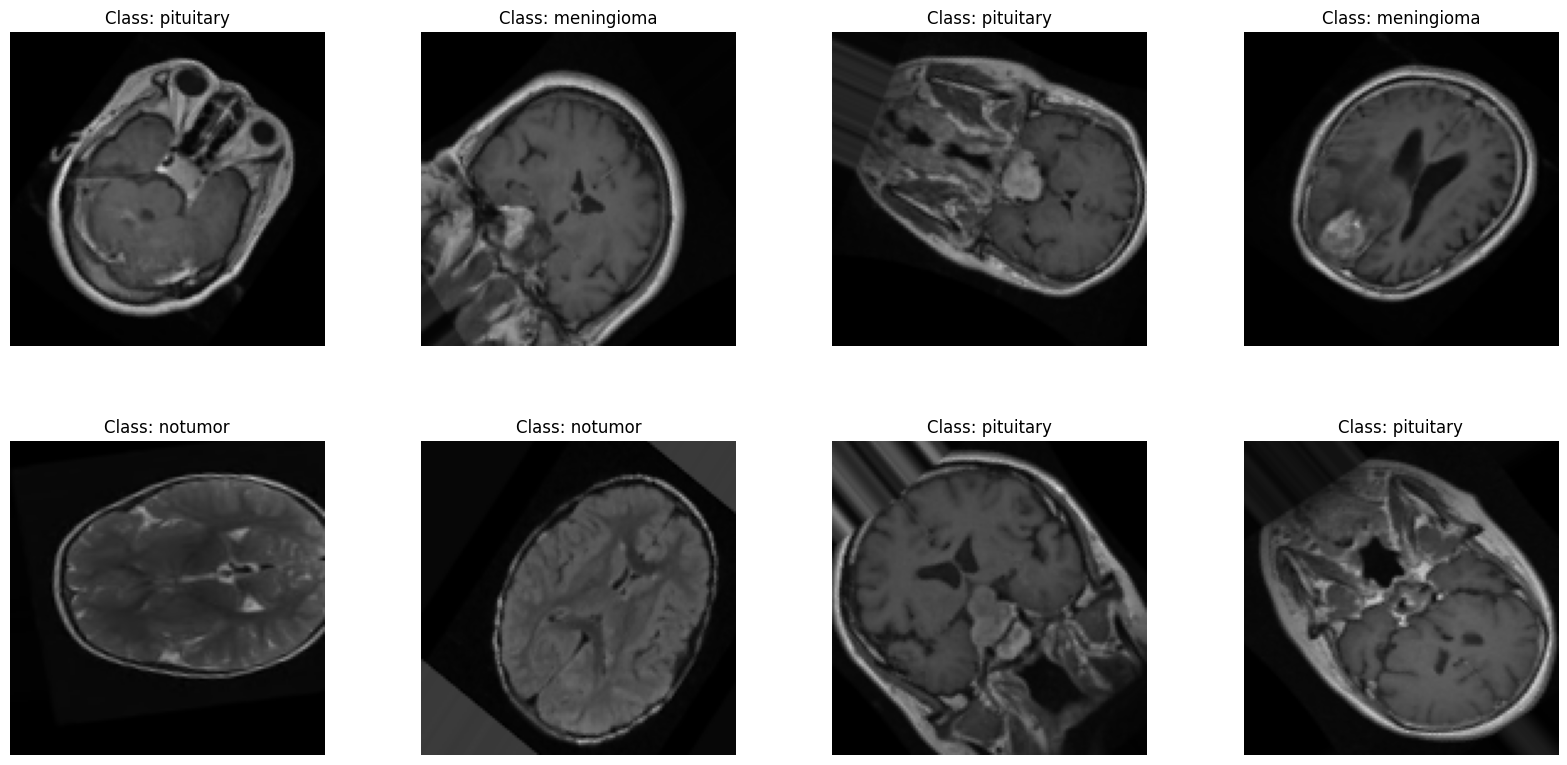

In [70]:
labels = [k for k in train_set.class_indices]
sample_generate = train_set.__next__()

images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

for i in range(8):
    plt.subplot(4 , 4, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis("off")

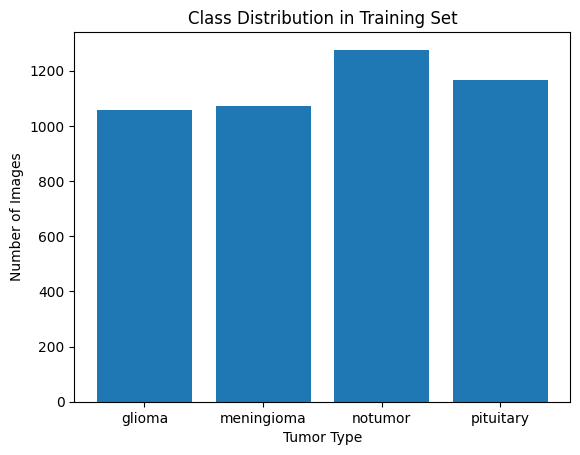

In [98]:
import matplotlib.pyplot as plt
import numpy as np

class_counts = np.bincount(train_set.labels) # Get counts for each class
class_labels = list(train_set.class_indices.keys()) # Get class labels

plt.bar(class_labels, class_counts)
plt.title('Class Distribution in Training Set')
plt.xlabel('Tumor Type')
plt.ylabel('Number of Images')
plt.show()

# Defining the DenseNet201 Model

In [71]:
base_model = DenseNet201(include_top = False,
                       weights = 'imagenet',
                       input_shape = (img_size,img_size,3))

In [72]:
num_layers = len(base_model.layers)
num_layers

707

In [73]:
# Freeze layers up to a certain index
freeze_index = None
for i, layer in enumerate(base_model.layers):
    if 'conv5' in layer.name:
        freeze_index = i
        break

if freeze_index is not None:
    for layer in base_model.layers[:freeze_index]:
        layer.trainable = False

In [74]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model.add(Dropout(0.4))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 4, 4, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1920)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         491,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,814,788 (71.77 MB)

 Trainable params: 7,475,204 (28.52 MB)

 Non-trainable params: 11,339,584 (43.26 MB)

In [75]:
optimizer = Adam(learning_rate=0.00001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

Defining model callbacks


In [76]:
def training_callbacks():

    # save best model regularly
    save_best_model = ModelCheckpoint(filepath = 'model.keras',
        monitor = 'val_accuracy', save_best_only = True, verbose = 1)

    # reduce learning rate when it stops decreasing
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4,
                              patience = 3, min_lr = 1e-10, verbose = 1, cooldown = 1)

    # stop training early if no further improvement
    early_stopping = EarlyStopping(
        monitor = 'val_loss', min_delta = 1e-2, patience = 5, verbose = 1,
        mode = 'min', baseline = None, restore_best_weights = True)

    return save_best_model, reduce_lr, early_stopping

#Model training and Evaluation

In [77]:
history = model.fit(
    train_set,
    epochs=20,
    validation_data=val_set,
    callbacks=training_callbacks()
)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.4224 - loss: 1.4293
Epoch 1: val_accuracy improved from -inf to 0.63190, saving model to model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 219s 825ms/step - accuracy: 0.4232 - loss: 1.4274 - val_accuracy: 0.6319 - val_loss: 1.0080 - learning_rate: 1.0000e-05
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.7216 - loss: 0.7415
Epoch 2: val_accuracy improved from 0.63190 to 0.70026, saving model to model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 51s 345ms/step - accuracy: 0.7218 - loss: 0.7411 - val_accuracy: 0.7003 - val_loss: 0.8191 - learning_rate: 1.0000e-05
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.7940 - loss: 0.5862
Epoch 3: val_accuracy improved from 0.70026 to 0.72831, saving model to model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 352ms/step - accuracy: 0.7941 - loss: 0.5860 - val_accuracy: 0.7283 - val_loss: 0.7601 - learning_rate: 1.0000e-05
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s

In [78]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_set, verbose=2)
print('Test accuracy:', test_acc)

41/41 - 20s - 498ms/step - accuracy: 0.8520 - loss: 0.4504
Test accuracy: 0.852021336555481


Accuracy and Loss curve of training and validation

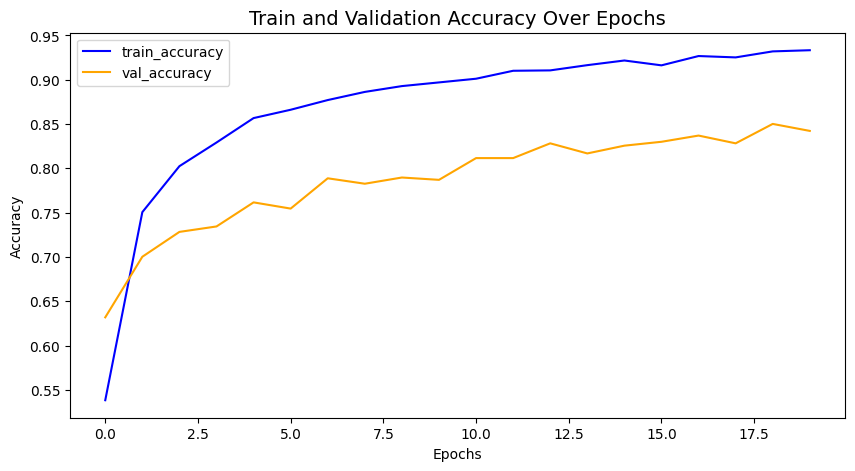

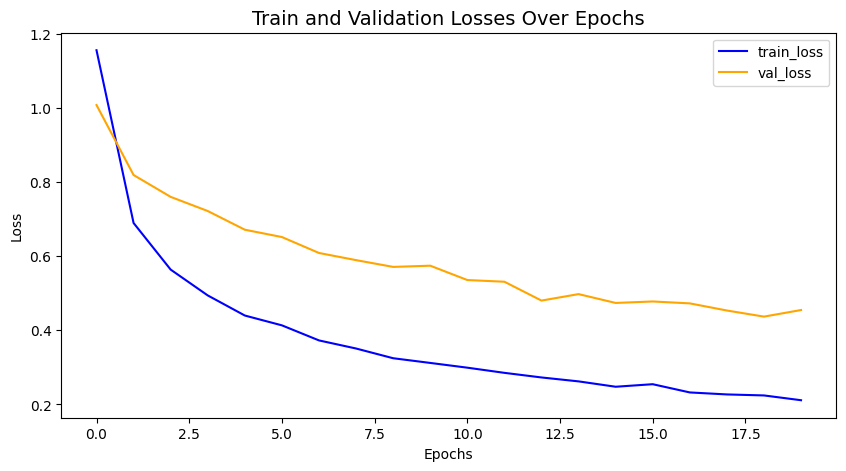

In [99]:
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))

plt.plot(history.history["accuracy"], label="train_accuracy", color='blue')
plt.plot(history.history["val_accuracy"], label="val_accuracy", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy Over Epochs", fontsize=14)
plt.legend()

# Plot training and validation loss
plt.figure(figsize=(10, 5))

plt.plot(history.history["loss"], label="train_loss", color='blue')
plt.plot(history.history["val_loss"], label="val_loss", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()

plt.show()



plt.show()

Confusion Matrix

41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 553ms/step


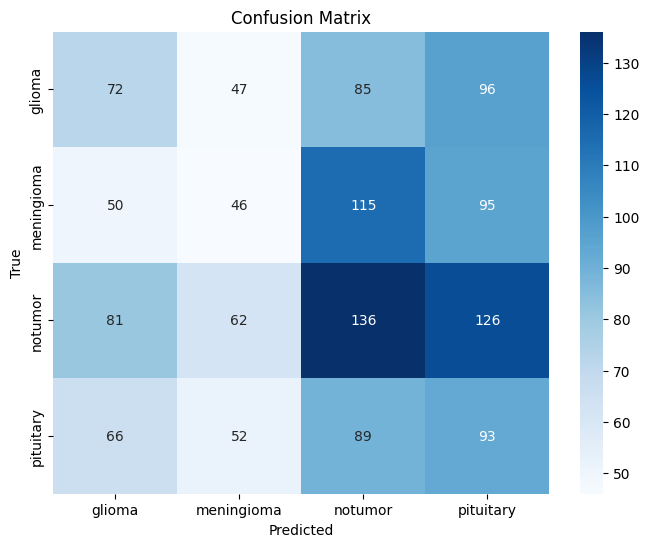

              precision    recall  f1-score   support

      glioma       0.27      0.24      0.25       300
  meningioma       0.22      0.15      0.18       306
     notumor       0.32      0.34      0.33       405
   pituitary       0.23      0.31      0.26       300

    accuracy                           0.26      1311
   macro avg       0.26      0.26      0.26      1311
weighted avg       0.26      0.26      0.26      1311



In [80]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions using the trained model
y_pred = model.predict(test_set)
y_true = test_set.labels

# Generate a confusion matrix
confusion_mat = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=test_set.class_indices.keys(), yticklabels=test_set.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# You can also generate a classification report for more detailed metrics
class_report = classification_report(y_true, np.argmax(y_pred, axis=1), target_names=test_set.class_indices.keys())
print(class_report)

#Predicting results, with indivial probability of each class

In [82]:
from tensorflow.keras.preprocessing import image

# Custom function to load and predict label for the image
def predict(img_rel_path):
    # Import Image from the path with size of (224, 224)
    img = image.load_img(img_rel_path, target_size=(img_size, img_size))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = model.predict(img[np.newaxis, ...])

    # Label array
    labels = [k for k in train_set.class_indices]

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))

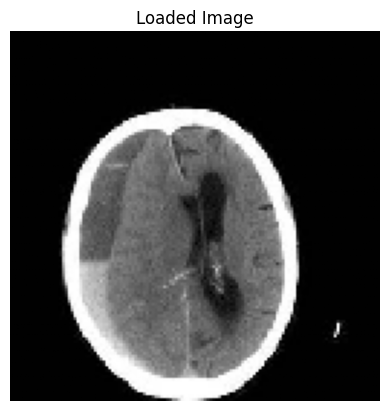

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Maximum Probability:  0.6192253
Classified: notumor 



-------------------Individual Probability--------------------------------

GLIOMA : 24.13 %
MENINGIOMA : 11.08 %
NOTUMOR : 61.92 %
PITUITARY : 2.86 %


In [101]:
predict("/content/dataset/Testing/notumor/Te-noTr_0000.jpg")


#Predicting the test data Class Labels

In [91]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pandas as pd
import numpy as np

folder_path = '/content/dataset/Testing'

data = []

# loop over the subfolders in the folder
for subfolder_name in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder_name)

    # Check if it's a directory before proceeding
    if os.path.isdir(subfolder_path):
        # loop over the files in the subfolder
        for file_name in os.listdir(subfolder_path):
            # load the image file
            img_path = os.path.join(subfolder_path, file_name)

            # Check if it's a file before processing
            if os.path.isfile(img_path):
                img = load_img(img_path, target_size=(128, 128))

                # preprocess the image for the model
                img_array = img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)

                # use the model to predict the class
                preds = model.predict(img_array)
                class_idx = np.argmax(preds)

                # create a tuple with the file name and predicted class
                data.append((file_name, class_idx))

# create a Pandas data frame from the list of tuples
df = pd.DataFrame(data, columns=['picture', 'class'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

In [93]:
df

,picture,class
0,Te-me_0232.jpg,2
1,Te-me_0226.jpg,1
2,Te-me_0137.jpg,2
3,Te-me_0054.jpg,1
4,Te-me_0256.jpg,1
...,...,...
1306,Te-pi_0050.jpg,1
1307,Te-pi_0041.jpg,2
1308,Te-pi_0114.jpg,1
1309,Te-pi_0132.jpg,1


In [95]:
class_labels = ['giloma', 'meningioma', 'notumor', 'pituitary']
df['labels'] = df['class'].apply(lambda x: class_labels[x])

In [96]:
df.to_csv('predictions.csv', index=False)

In [102]:
df

,picture,class,labels
0,Te-me_0232.jpg,2,notumor
1,Te-me_0226.jpg,1,meningioma
2,Te-me_0137.jpg,2,notumor
3,Te-me_0054.jpg,1,meningioma
4,Te-me_0256.jpg,1,meningioma
...,...,...,...
1306,Te-pi_0050.jpg,1,meningioma
1307,Te-pi_0041.jpg,2,notumor
1308,Te-pi_0114.jpg,1,meningioma
1309,Te-pi_0132.jpg,1,meningioma
